<span style="color:#44f;font-weight:bold;">Codes for CNS2025: Lecture 5</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simulate Integrate-and-fire model

In [2]:
def simulate_lif_model(duration,delta_t=0.001,input_current=None,rng=None,seed=1234,**parameters):
    '''Simulate integrate-and-fire model
    
    Parameters
    ----------
    duration :      Time duration to simulate the dynamics for
    input_current : Stimulus input current
    delta_t :       Simulation time-step size (time between frames)
    rng :           Random number generator
    seed :          Seed to use if rng not supplied
    parameters :    Other model paramters
    
    Returns
    -------
    membrane_potential : Membrane potential trace
    spike_train :        Spike train (frame-based)
    input_current :      Input current used
    '''
    # Parameters for simulation
    default_parameters = {
        'resting_potential':          -70, # (mV)
        'reset_potential':            -80, # (mV)
        'noise_amplitude':           0.03, # (mA s^{-1/2})
        'input_resistance':            50, # (ohm)
        'background_current':         0.1, # (mA)
        'firing_threshold':           -50, # (mV)
        'membrane_time_constant':    0.02, # (s)
        'initial_membrane_potential': -70, # (mV)
    }
    for p in parameters:
        if not p in default_parameters:
            raise TypeError(f'Unknown parameter: {p}')
    parameters = default_parameters|parameters

    frame_times = np.arange(0,duration,delta_t)
    if rng is None: rng = np.random.default_rng(seed)
    if input_current is None:
        input_current = parameters['noise_amplitude']*rng.normal(size=len(frame_times))
    membrane_potential = parameters['initial_membrane_potential']
    membrane_potential_trace = []  # Trace of membrane potential
    spike_train = []  # spike train
    for i,time in enumerate(frame_times):
        total_input = input_current[i]/np.sqrt(delta_t)+parameters['background_current']
        membrane_potential += delta_t*(
            parameters['resting_potential']
            -membrane_potential
            +total_input*parameters['input_resistance']
        )/parameters['membrane_time_constant']
        membrane_potential_trace.append(membrane_potential)
        if membrane_potential>parameters['firing_threshold']:
            membrane_potential = parameters['reset_potential']
            spike_train.append(1)
        else: spike_train.append(0)
    return np.array(membrane_potential_trace),np.array(spike_train),input_current

Perform a really long simulation to get lots of data

In [3]:
potentials,spike_train,inputs = simulate_lif_model(
    10000,delta_t=(delta_t:=.001),seed=1234,noise_amplitude=(sigma:=.03)
)

In [4]:
sta_range = np.array([-0.5,0.1])
sta_rindex_start,sta_rindex_end = (sta_range/delta_t).astype(int)
sta_times = np.arange(*sta_range,delta_t)
sta = np.mean([
    inputs[i+sta_rindex_start:i+sta_rindex_end]
    for i in range(-sta_rindex_start,len(inputs)-sta_rindex_end)
    if spike_train[i]
],axis=0)-inputs.mean()

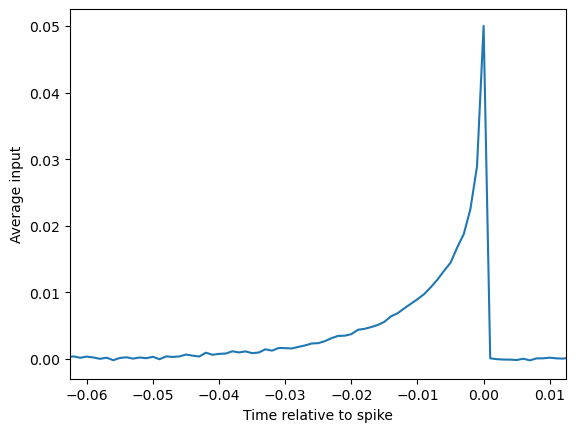

In [5]:
plt.plot(sta_times,sta)
plt.xlabel('Time relative to spike')
plt.ylabel('Average input')
plt.xlim(sta_range/8)
plt.show()

## Filtered stimulus

In [6]:
rng = np.random.default_rng(1234)
inputs = sigma*rng.normal(size=int(10/delta_t))
times = np.arange(len(inputs))*delta_t

In [7]:
mix_times = np.arange(-.5,.5,delta_t)
mix_weights = np.exp(-(mix_times/0.1)**2)
mix_weights /= (delta_t*mix_weights.sum())

In [8]:
front_drop = (mix_times<0).sum()
# Filter the stimulus, making it smoother
inputs_alt = np.convolve(inputs-inputs.mean(),mix_weights)[front_drop:front_drop-len(mix_times)+1]
# Preserve mean and standard deviation
inputs_alt = (inputs_alt-inputs_alt.mean())*inputs.std()/inputs_alt.std()+inputs.mean()

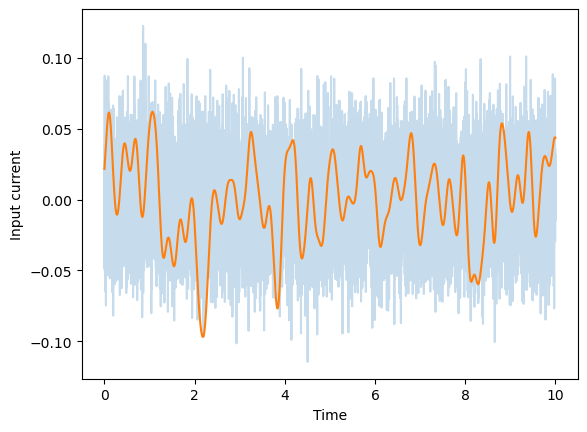

In [9]:
plt.plot(times,inputs,alpha=0.25)
plt.plot(times,inputs_alt)
plt.xlabel('Time')
plt.ylabel('Input current')
plt.show()

### Simulate with the alternative input
Perform virtual experiment to generate a spike train from the input

In [10]:
potentials_alt,spike_train_alt,_ = simulate_lif_model(10,delta_t,inputs_alt)

In [11]:
times = np.arange(len(inputs_alt))*delta_t
#win_times = np.arange(-0.1,0.1,delta_t)
#win_weights = np.ones_like(win_times)/(delta_t*len(win_times))
win_times = np.arange(-0.3,0.3,delta_t)
win_weights = np.exp(-(win_times/0.05)**2/2)
win_weights /= delta_t*win_weights.sum()
front_drop = (win_times<0).sum()
estimated_rates = np.convolve(spike_train_alt,win_weights)[front_drop:front_drop-len(win_weights)+1]

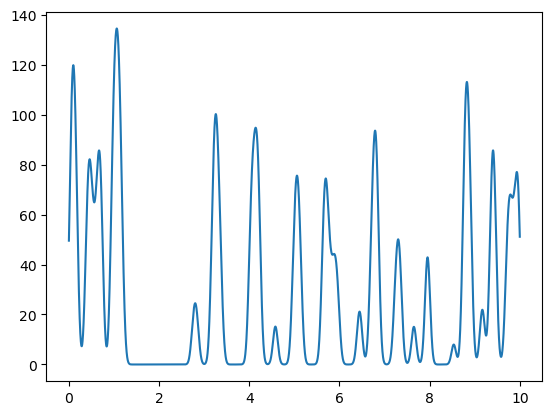

In [12]:
plt.plot(times,estimated_rates)
plt.show()

### Use STA to estimate rate from input

In [13]:
front_drop = (sta_times>0).sum()
sta_convolved = np.convolve(inputs_alt,sta[::-1])[front_drop:front_drop-len(sta)+1]

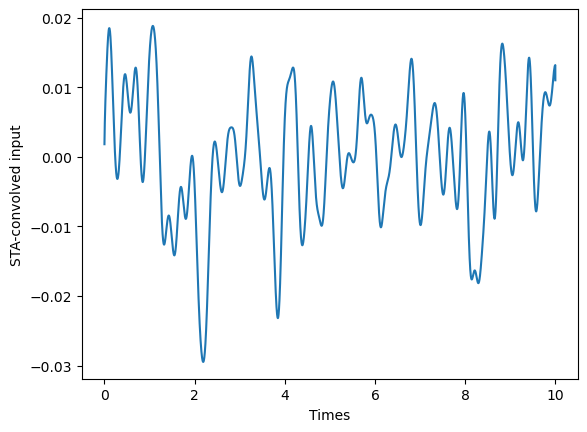

In [14]:
plt.plot(times,sta_convolved)
plt.xlabel('Times')
plt.ylabel('STA-convolved input')
plt.show()

In [15]:
from scipy.optimize import curve_fit

In [16]:
def relu_func(x,m):
    return m*x*(x>0)

def softplus_func(x,m,t,s):
    return m*np.log(1+np.exp(s*(x-t)))

def sigmoidal_func(x,m,t,s):
    return m/(1+np.exp(s*(t-x)))

def tanh_func(x,m,t,s):
    v = m*np.tanh(s*(x-t))
    return v*(v>0)

In [17]:
# Find best parameters for the rectifiers
relu_prm,_ = curve_fit(relu_func,sta_convolved,estimated_rates)
soft_prm,_ = curve_fit(softplus_func,sta_convolved,estimated_rates,bounds=((1,-0.2,0.1),(400,0.2,400)))
sgmd_prm,_ = curve_fit(sigmoidal_func,sta_convolved,estimated_rates,bounds=((100,0.001,100),(400,0.1,400)))
tanh_prm,_ = curve_fit(tanh_func,sta_convolved,estimated_rates,bounds=((100,-0.1,100),(400,0.1,400)))

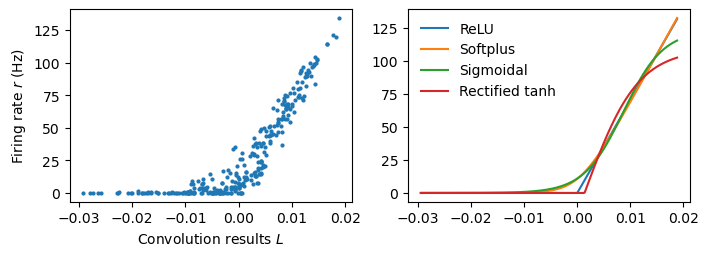

In [18]:
f,(a,b) = plt.subplots(1,2,figsize=(8,2.5))
indices = rng.integers(0,len(sta_convolved),300) # Randomly select 300 points
a.plot(sta_convolved[indices],estimated_rates[indices],'o',markersize=2)
a.set_xlabel(r'Convolution results $L$')
a.set_ylabel('Firing rate $r$ (Hz)')

xvalues = np.linspace(sta_convolved.min(),sta_convolved.max(),256)
for func,prm,name in [
    (relu_func,relu_prm,'ReLU'),
    (softplus_func,soft_prm,'Softplus'),
    (sigmoidal_func,sgmd_prm,'Sigmoidal'),
    (tanh_func,tanh_prm,'Rectified tanh')
]:
    b.plot(xvalues,func(xvalues,*prm),label=name)
b.legend(frameon=False)
plt.show()

# Spike train in event-based representation

## Independent intervals (renewal processes)
Generate Poisson spike train from exponentially distributed intervals

In [19]:
duration = 20 # For 20s
rng = np.random.default_rng(1234)
rng_state = rng.bit_generator.state

# List appending loop
spike_train0 = []
t = 0
while True:
    t += rng.exponential()
    if t>duration: break
    spike_train0.append(t)
spike_train0 = np.array(spike_train0)

rng.bit_generator.state = rng_state # Restore RNG state

# Alternative approach, need to know the number of spikes
spike_train1 = np.cumsum(rng.exponential(size=len(spike_train0)))

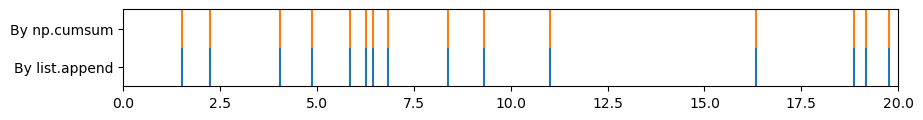

In [20]:
plt.figure(figsize=(10,1))
plt.vlines(spike_train0,0,1)
plt.vlines(spike_train1,1,2,color='C1')
plt.ylim(0,2)
plt.xlim(0,duration)
plt.yticks([0.5,1.5],["By list.append","By np.cumsum"])
plt.show()

### A narrower interval distribution

In [21]:
softplus = lambda x:np.log(1+np.exp(x))

In [22]:
rng.bit_generator.state = rng_state
t = 0
spike_train2 = [t:=t+softplus(rng.normal()/2+1) for _ in range(16)]

rng.bit_generator.state = rng_state
spike_train3 = np.cumsum(softplus(rng.normal(size=16)/2+1))

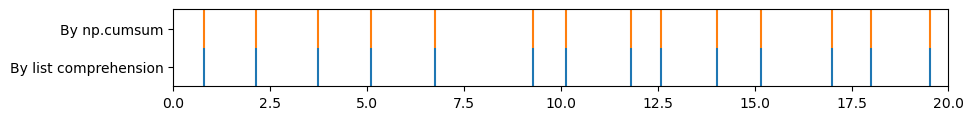

In [23]:
plt.figure(figsize=(10,1))
plt.vlines(spike_train2,0,1)
plt.vlines(spike_train3,1,2,color='C1')
plt.ylim(0,2)
plt.xlim(0,20)
plt.yticks([0.5,1.5],["By list comprehension","By np.cumsum"])
plt.show()

### Generator approach

In [24]:
def spike_generator(duration):
    t = 0
    while True:
        t += rng.exponential()
        if t>duration: break
        yield t

In [25]:
rng.bit_generator.state = rng_state
spike_train4 = list(spike_generator(20))

### Recursive approach

In [26]:
def gen_more_spikes(t,time_limit):
    t += rng.exponential()
    return [] if t>time_limit else [t]+gen_more_spikes(t,time_limit)

In [27]:
rng.bit_generator.state = rng_state
spike_train5 = gen_more_spikes(0,20)

## Sliding window

In [28]:
# Binned frames
delta_t = 0.125 # Time step
time_range = np.array([0,spike_train0[-1]//1+1.5]) # Time range
times = np.arange(*time_range,delta_t)+delta_t/2 # Time at the center of time bins

In [29]:
spike_train1

array([ 1.52373024,  2.23838105,  4.05130676,  4.86422525,  5.84652732,
        6.26797429,  6.4558665 ,  6.82327802,  8.37401728,  9.31493736,
       11.02313827, 16.32725634, 18.87123803, 19.17908105, 19.76951775])

In [30]:
frame_spike = np.zeros_like(times)
# Use integer array indexing
frame_spike[(spike_train0/delta_t).astype(int)] = 1

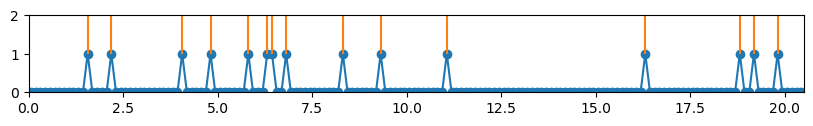

In [31]:
plt.figure(figsize=(10,1))
plt.plot(times,frame_spike,'o-')
plt.vlines(times[np.where(frame_spike)],1,2,color='C1')
plt.ylim(0,2)
plt.xlim(time_range)
plt.show()

In [32]:
def event_sliding_window(points,win_size=10):
    '''Calculate sliding window time histogram for event-based spike train
 
    Parameters
    ----------
    points :  Array of spike time points
    win_size : Window size

    Returns
    -------
    times : Time points of rate changes
    rates : Rates at the time points
    '''
    win_start = points[0]-win_size # Starting time
    win_start_index,win_end_index = 0,0 # Indices of spikes at two ends
    num_points = len(points) # Total number of spikes 
    times = [win_start]  # Time points to output
    rates = [0]          # Firing rates
    while win_start_index<num_points:
        if win_end_index<num_points and points[win_end_index]<points[win_start_index]+win_size:
            if win_start<points[win_end_index]-win_size: # Output only when window moves
                next_win_start = points[win_end_index]-win_size
                if rates[-1]==win_end_index-win_start_index: times[-1]=next_win_start # Merge with previous interval
                else:
                    times.extend((win_start,next_win_start))
                    rates.extend((win_end_index-win_start_index,win_end_index-win_start_index))
                win_start = next_win_start
            win_end_index += 1
        else:
            if win_start<points[win_start_index]: # Output only when window moves
                next_win_start = points[win_start_index]
                if rates[-1]==win_end_index-win_start_index: times[-1] = next_win_start # Merge with previous interval
                else:
                    times.extend((win_start,next_win_start))
                    rates.extend((win_end_index-win_start_index,win_end_index-win_start_index))
                win_start = next_win_start
            win_start_index += 1
    times.append(win_start)
    rates.append(0)
    return np.array(times)+win_size/2,np.array(rates)/win_size

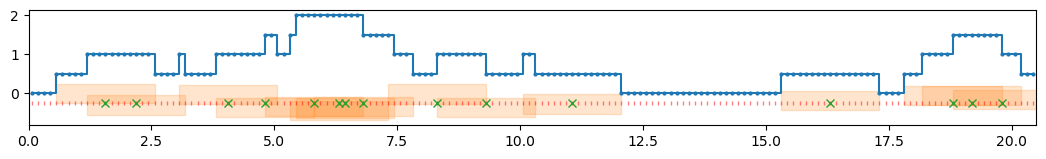

In [33]:
# Frame-based sliding window
win_size = 2.0
win_times = np.arange(-win_size/2,win_size/2,delta_t) # Window time frames
win_weights = np.ones_like(win_times)
win_weights /= (win_weights.sum()*delta_t) # Normalize window kernel
front_drop = (win_times<0).sum()

estimated_rates = np.convolve(frame_spike,win_weights)[front_drop:front_drop-len(win_times)+1]
plt.figure(figsize=(13,1.5))
plt.vlines(times,-0.3,-0.2,color='red',lw=1,alpha=0.5)
plt.plot(times,estimated_rates,'o-',ds='steps-post',markersize=2)
rng.bit_generator.state = rng_state
for t in times[(spike_train0/delta_t).astype(int)]:
    y = (rng.uniform()-.5)/2
    plt.fill_between([t-win_size/2,t+win_size/2],y-0.5,y,color='C1',alpha=0.2)
#plt.plot(np.floor(spike_train0/delta_t)*delta_t+delta_t/2,np.zeros_like(spike_train0)-0.25,'x',color='C2',clip_on=False)
plt.plot(times[(spike_train0/delta_t).astype(int)],np.zeros_like(spike_train0)-0.25,'x',color='C2',clip_on=False)
plt.xlim(*time_range)
plt.show()

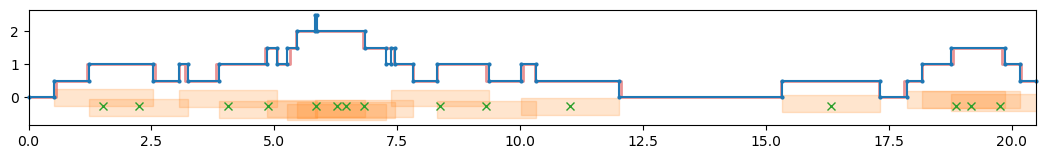

In [34]:
# Event-based sliding window
sw_times,sw_rates = event_sliding_window(spike_train0,win_size)
indices = (sw_times>=time_range[0])*(sw_times<=time_range[1])

# Truncate the results to the time range
sw_times,sw_rates = sw_times[indices],sw_rates[indices]
sw_times = np.r_[time_range[0],sw_times,time_range[1]]
sw_rates = np.r_[sw_rates[0],sw_rates,sw_rates[-1]]

plt.figure(figsize=(13,1.5))
plt.plot(sw_times,sw_rates,'o-',markersize=2,clip_on=False)
plt.plot(times,estimated_rates,clip_on=False,color='C3',ds='steps-post',zorder=-1,lw=2,alpha=.5)
rng.bit_generator.state = rng_state
for t in spike_train0:
    y = (rng.uniform()-.5)/2
    plt.fill_between([t-win_size/2,t+win_size/2],y-0.5,y,color='C1',alpha=0.2)
plt.plot(spike_train0,np.zeros_like(spike_train0)-0.25,'x',color='C2',clip_on=False)
plt.xlim(time_range)
plt.show()

## Gaussian distribution
\begin{equation}
    P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x}{\sigma}\right)^2}
\end{equation}

In [35]:
def gaussian_func(xs,sigma):
    return np.exp(-(xs/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

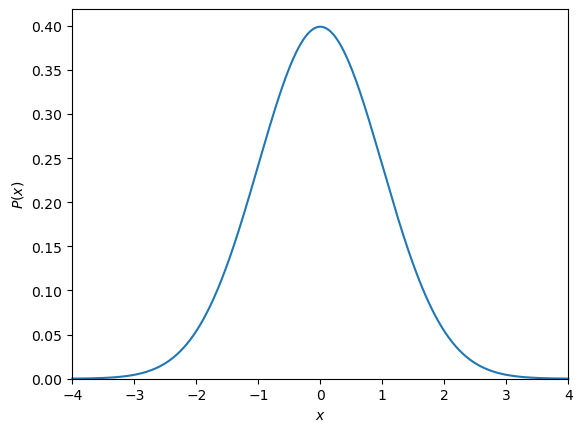

In [36]:
xr = np.r_[-4,4]
xs = np.linspace(*xr,2**10+1)
dx = xs[1]-xs[0]
gs = gaussian_func(xs,1.0)

plt.plot(xs,gs,clip_on=False)
plt.xlim(xr)
plt.ylim(0,None)

plt.ylabel('$P(x)$')
plt.xlabel('$x$')
plt.show()

### Generate Gaussian distributed random variables

In [37]:
gs_max = gs.max()
num_xs = len(xs)

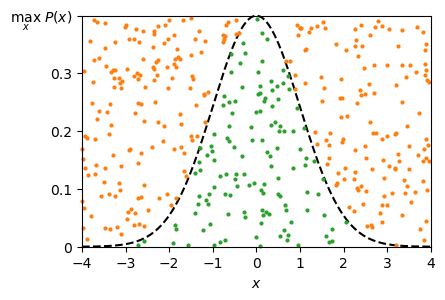

In [38]:
plt.figure(figsize=(4.5,3))
plt.plot(xs,gs,'--',color='k',clip_on=False,label='$P(x)$')
vs = []
rng = np.random.default_rng(123)
for _ in range(128):
    while (v:=rng.uniform(0,gs_max))>gs[(xi:=rng.integers(0,num_xs))]: # Drop if above curve
        plt.plot([xs[xi]],[v],'o',color='C1',markersize=2,clip_on=False)
    plt.plot([xs[xi]],[v],'o',color='C2',markersize=2,clip_on=False)
    vs.append(xs[xi]) # Keep
plt.xlim(xr)
plt.xlabel('$x$')
plt.ylim(0,gs_max)
plt.yticks([0,0.1,0.2,0.3,gs_max],[0,0.1,0.2,0.3,r'$\max_x\;P(x)$'])
plt.show()

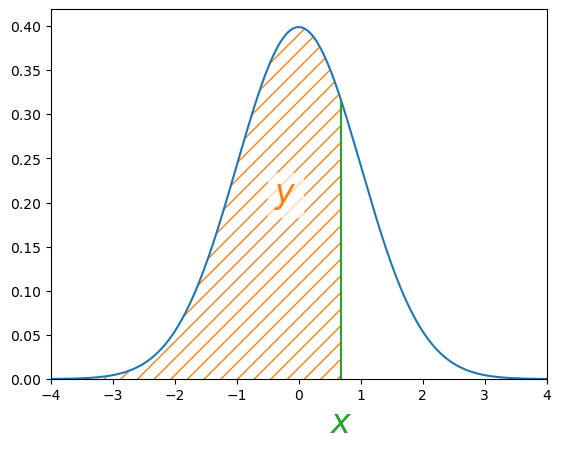

In [39]:
plt.plot(xs,gs)
plt.fill_between(xs[:600],gs[:600],hatch='//',facecolor='None',edgecolor='C1',linewidth=0)
plt.vlines(xs[600],0,gs[600],color='C2',ls='None')
plt.text(xs[600],-.06,'$x$',ha='center',fontsize=24,color='C2')
plt.text(-0.4,0.2,'$y$',fontsize=24,color='C1',backgroundcolor='#fffa')
plt.ylim(0,)
plt.xlim(xr)
plt.show()

In [40]:
from scipy.special import erfinv,erf

In [41]:
rng = np.random.default_rng(123)
vs = erfinv(rng.uniform(size=1024)*2-1)*np.sqrt(2)

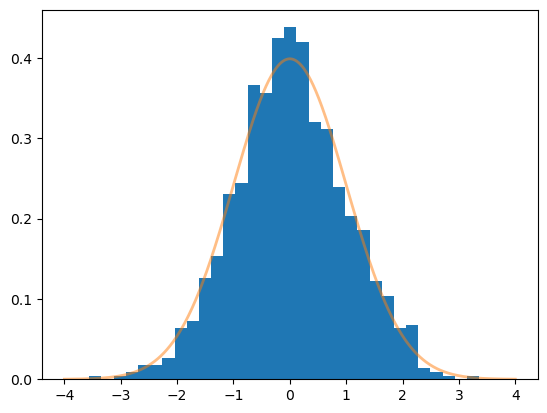

In [42]:
plt.hist(vs,32,density=True)
plt.plot(xs,gs,lw=2,alpha=0.5)
plt.show()

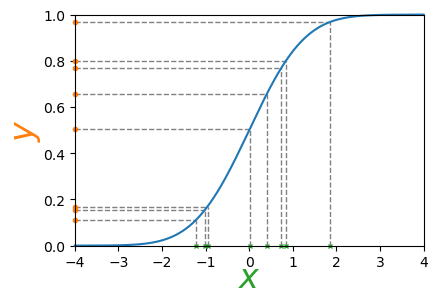

In [43]:
rng = np.random.default_rng(111)
ys = rng.uniform(size=8)
vs = erfinv(ys*2-1)*np.sqrt(2)
plt.figure(figsize=(4.5,3))
plt.hlines(ys,-4,vs,color='gray',ls='--',lw=1)
plt.vlines(vs,0,ys,color='gray',ls='--',lw=1)
plt.plot(xs,(1+erf(xs/np.sqrt(2)))/2,clip_on=False)
plt.plot(np.zeros_like(ys)-4,ys,'o',markersize=3,clip_on=False)
plt.plot(vs,np.zeros_like(vs),'x',markersize=3,clip_on=False)
plt.xlabel('$x$',color='C2',fontsize=24,labelpad=-6)
plt.ylabel('$y$',color='C1',fontsize=24,labelpad=0)
plt.xlim(-4,4)
plt.ylim(0,1)
plt.show()

## Exponential distribution

In [44]:
def expdis(x,mu=1):
    return np.exp(-xs/mu)*(xs>=0)

In [45]:
xr = np.r_[-1,7]
xs = np.linspace(*xr,2**10+1)
es = expdis(xs)

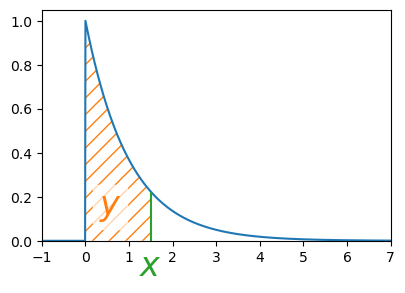

In [46]:
plt.figure(figsize=(4.5,3))
plt.plot(xs,es)
xn = 320
plt.fill_between(xs[:xn],es[:xn],hatch='//',facecolor='None',edgecolor='C1',linewidth=0)
plt.vlines(xs[xn],0,es[xn],color='C2',ls='None')
plt.text(xs[xn],-.16,'$x$',ha='center',fontsize=24,color='C2')
plt.text(0.3,0.12,'$y$',fontsize=24,color='C1',backgroundcolor='#fffa')
plt.ylim(0,)
plt.xlim(xr)
plt.show()

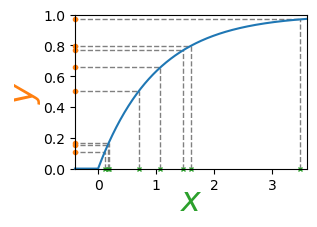

In [47]:
rng = np.random.default_rng(111)
ys = rng.uniform(size=8)
vs = -np.log(1-ys)
plt.figure(figsize=(3,2))
plt.hlines(ys,-4,vs,color='gray',ls='--',lw=1)
plt.vlines(vs,0,ys,color='gray',ls='--',lw=1)
xss = xs[(xs>-.4)&(xs<3.6)]
plt.plot(xss,(1-np.exp(-xss))*(xss>=0),clip_on=False)
plt.plot(np.zeros_like(ys)-.4,ys,'o',markersize=3,clip_on=False)
plt.plot(vs,np.zeros_like(vs),'x',markersize=3,clip_on=False)
plt.xlabel('$x$',color='C2',fontsize=24,labelpad=-6)
plt.ylabel('$y$',color='C1',fontsize=24,labelpad=0)
plt.xlim(-0.4,3.6)
plt.ylim(0,1)
plt.show()

## Generate spike train

In [48]:
import matplotlib.lines as lines

In [49]:
# generate intervals
rng = np.random.default_rng(1234)
rst = rng.bit_generator.state
ivs = rng.exponential(size=32)
st = np.cumsum(ivs) 

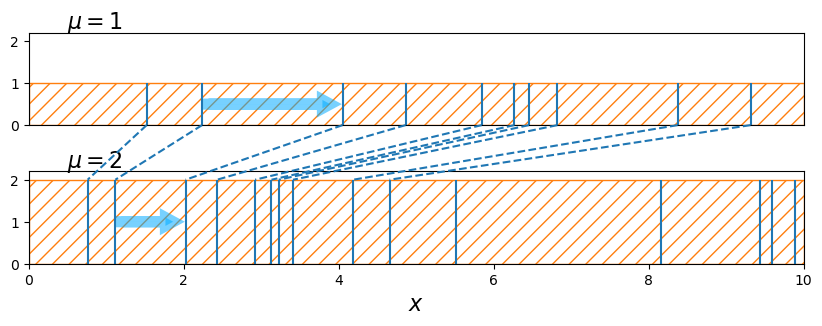

In [50]:
f,aa = plt.subplots(2,1,figsize=(10,3))
f.subplots_adjust(hspace=0.5)
ia = -1
for a,h in zip(aa,[1,2]):
    a.vlines(sts:=st[st/h<10]/h,0,h)
    a.fill_between([0,10],[h,h],hatch='//',facecolor="None",edgecolor='C1')
    a.set_xlim(0,10)
    a.set_ylim(0,2.2)
    if ia<0: ia = np.diff(sts).argmax()
    a.arrow(
        sts[ia]+0.08,h/2,sts[ia+1]-sts[ia]-0.24,0,
        lw=8,length_includes_head=True,
        color='#0af8',head_width=0.2,head_length=0.1
    )
    a.text(0.5,2.3,fr'$\mu={h}$',fontsize=16)
aa[0].set_xticks([])
aa[1].set_xlabel(r'$x$',fontsize=16)
for t in st[st<10]:
    ls = np.array([
        f.transFigure.inverted().transform(a.transData.transform(p))
        for a,p in zip(aa,[[t,0],[t/2,2]])
    ]).T
    f.add_artist(lines.Line2D(*ls,linestyle='--',color='C0'))
plt.show()

In [51]:
def gen_spikes(r,dt,rng=None,seed=123):
    '''Generate spike train from Poisson rate
 
    Parameters
    ----------
    r:  Array of spike rates
    dt: Time step size
    
    Returns
    -------
    Event-based spike train
    '''
    if rng is None: rng = np.random.default_rng(seed)
    i = 0
    s = 0
    spks = []
    while True:
        s += rng.exponential() # Area to advance for next spike
        while s>r[i]*dt: # Advance to next frame if enough area
            s -= r[i]*dt
            i += 1
            if i>=len(r): break # No more frame
        else:
            spks.append(i*dt+s/r[i]) # Spike time in this frame
            continue
        break
    return np.array(spks)

In [52]:
# Generate time varying spike rate
ts = np.arange(0,11)
rng = np.random.default_rng(123)
rs = rng.uniform(size=11)-0.5
rs[1:] = (rs[1:]+rs[:-1])/2
rs /= (2*rs.std())
rs = rs+1-rs.mean()
rs += 2-rs.max()

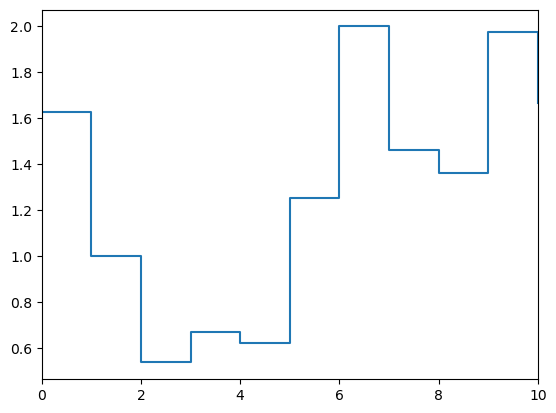

In [53]:
plt.step(ts,rs,where='post')
plt.xlim(0,10)
plt.show()

In [54]:
rng.bit_generator.state = rst
vs = gen_spikes(rs,1,rng)

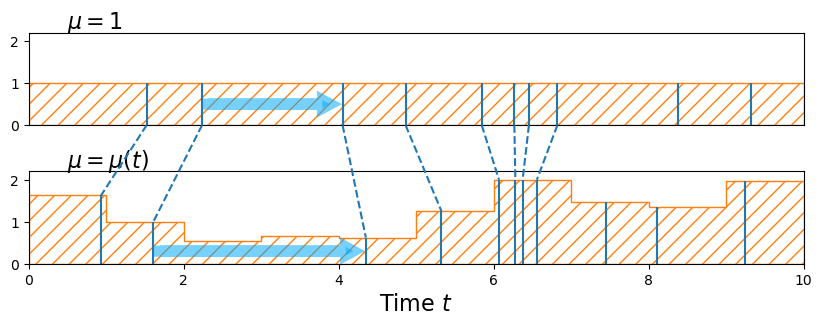

In [55]:
f,aa = plt.subplots(2,1,figsize=(10,3))
f.subplots_adjust(hspace=0.5)
a,h = aa[0],1
a.vlines(sts:=st[st/h<10]/h,0,h)
a.fill_between([0,10],[h,h],hatch='//',facecolor="None",edgecolor='C1')
a.set_xlim(0,10)
a.set_ylim(0,2.2)
a.set_xticks([])
a.arrow(
    sts[ia]+0.08,h/2,sts[ia+1]-sts[ia]-0.24,0,
    lw=8,length_includes_head=True,
    color='#0af8',head_width=0.2,head_length=0.1
)
a.text(0.5,2.3,fr'$\mu={h}$',fontsize=16)

a = aa[1]
a.vlines(vs,0,np.take(rs,vs.astype(int)))
a.fill_between(ts,0,rs,step='post',hatch='//',facecolor="None",edgecolor='C1')
a.set_xlim(0,10)
a.set_ylim(0,2.2)
a.arrow(
    vs[ia]+0.08,0.3,vs[ia+1]-vs[ia]-0.24,0,
    lw=8,length_includes_head=True,
    color='#0af8',head_width=0.2,head_length=0.1
)
a.text(0.5,2.3,fr'$\mu=\mu(t)$',fontsize=16)
a.set_xlabel('Time $t$',fontsize=16)

for i in range(8):
    ls = np.array([
        f.transFigure.inverted().transform(a.transData.transform(p))
        for a,p in zip(aa,[[st[i],0],[vs[i],rs[int(vs[i])]]])
    ]).T
    f.add_artist(lines.Line2D(*ls,linestyle='--',color='C0'))
plt.show()

# Technical python...

In [56]:
rng = np.random.default_rng(123)

The execution time can be measured per cell with the magic commands: `%%time` or `%%timeit`

In [57]:
%%time
# List appending loop
spk0 = []
t = 0
while True:
    t += rng.exponential()
    if t>100: break
    spk0.append(t)

CPU times: user 79 μs, sys: 4 μs, total: 83 μs
Wall time: 83.7 μs


In [58]:
%%timeit
# List appending loop
spk0 = []
t = 0
while True:
    t += rng.exponential()
    if t>100: break
    spk0.append(t)

38.4 μs ± 1.72 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
%%timeit
# Operating with numpy.array
spk1 = np.cumsum(rng.exponential(size=100))

2.66 μs ± 40 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
%%timeit
# List comprehension
t = 0
spk2 = [t:=t+rng.exponential() for _ in range(100)]

33.5 μs ± 774 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
x = rng.uniform(size=10000)

In [62]:
%%timeit
y = np.array([v**2 for v in x])

1.04 ms ± 6.15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [63]:
%%timeit
y = x**2

2.28 μs ± 87.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [64]:
aitb = ['dog','pig','cat','rat']

In [65]:
i = iter(aitb)
print(next(i))
print(next(i))
print(next(i))

dog
pig
cat


In [66]:
# Keep extracting and there will be an exception
print(next(i))
print(next(i))

rat


StopIteration: 

In [67]:
i = iter(aitb)
try:
    while True: print(next(i))
except StopIteration:
    pass

dog
pig
cat
rat


In [68]:
def gen_poisson(tt):
    t = 0
    while (t:=t+rng.exponential())<tt:
        yield t

In [69]:
rng.bit_generator.state = rng_state
i = iter(gen_poisson(10))
try:
    while True: print(next(i))
except StopIteration:
    pass

1.5237302442920129
2.238381047929837
4.051306763889668
4.864225247076579
5.846527318444624
6.2679742943075425
6.455866501256255
6.823278017386167
8.374017281892694
9.314937364672888


In [70]:
rng.bit_generator.state = rng_state
list(gen_poisson(10))

[1.5237302442920129,
 2.238381047929837,
 4.051306763889668,
 4.864225247076579,
 5.846527318444624,
 6.2679742943075425,
 6.455866501256255,
 6.823278017386167,
 8.374017281892694,
 9.314937364672888]

<hr>
<address style="color:#44f;font-style:italic;font-weight:bold;"><a href="https://cc.tir.tw/wk/2025cns">CNS2025</a></address>